In [2]:
import csv as csv
import numpy as np
import pandas as pd


In [3]:
# Reading using numpy arrays

data=[] 
csv_file_object = csv.reader(open('./data/train.csv', 'r')) 
for row in csv_file_object:
    data.append(row)
data = np.array(data) 



In [4]:
# Reading using pandas

df = pd.read_csv('./data/train.csv', header=0)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S


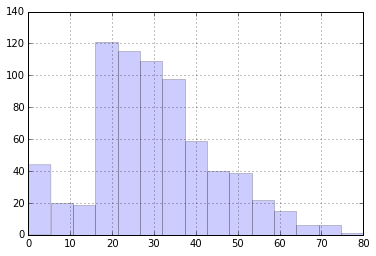

In [5]:
import pylab as P

df['Age'].dropna().hist(bins=15, range=(0,80), alpha = .2)

P.show()

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
df['Gender'] = df['Sex'].map({'male': 1, 'female': 0}).astype(int)

In [10]:
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df[(df['Gender'] == i) & \
                              (df['Pclass'] == j+1)]['Age'].dropna().median()
median_ages

array([[ 35. ,  28. ,  21.5],
       [ 40. ,  30. ,  25. ]])

In [11]:
df['AgeFill'] = df['Age']
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,22
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0,38
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,26
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0,35
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,35


In [12]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,AgeFill
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,714.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,29.699118
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,14.526497
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.420000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,20.125000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,28.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,38.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,80.000000


In [13]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,22
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0,38
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,26
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0,35
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,35


In [ ]:
df[ df['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head(10)

In [14]:
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[ (df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]
df[ df['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head(10)

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,25.0
17,1,2,NaN,30.0
19,0,3,NaN,21.5
26,1,3,NaN,25.0
28,0,3,NaN,21.5
29,1,3,NaN,25.0
31,0,1,NaN,35.0
32,0,3,NaN,21.5
36,1,3,NaN,25.0
42,1,3,NaN,25.0


In [15]:
df['AgeIsNull'] = pd.isnull(df.Age).astype(int)

# Feature Engineering
df['FamilySize'] = df['SibSp'] + df['Parch']

# As we know Pclass made a lot of effect on survival
df['Age*Class'] = df.AgeFill * df.Pclass

In [40]:
df.groupby(['Pclass', 'Embarked']).size()



Pclass  Embarked
1       C            85
        Q             2
        S           127
2       C            17
        Q             3
        S           164
3       C            66
        Q            72
        S           353
dtype: int64

In [42]:
# Setting null embarked values to S as it is the most common occurence
df['EmbarkedIsNull'] = pd.isnull(df.Embarked).astype(int)

In [47]:
df.loc[df.Embarked.isnull(), 'Embarked'] = 'S'

In [48]:
df['EmbarkedInt'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [49]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill,AgeIsNull,FamilySize,Age*Class,EmbarkedInt,EmbarkedIsNull
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,22,0,1,66,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0,38,0,1,38,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,26,0,0,78,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0,35,0,1,35,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,35,0,0,105,0,0


In [50]:
# Removing object columns. Need to revisit Name for text parsing
# TODO: Revisit Name and Cabin Parsing

df = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', "Age"], axis=1) 

In [51]:
df.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Gender,AgeFill,AgeIsNull,FamilySize,Age*Class,EmbarkedInt,EmbarkedIsNull
0,1,0,3,1,0,7.2500,1,22,0,1,66,0,0
1,2,1,1,1,0,71.2833,0,38,0,1,38,1,0
2,3,1,3,0,0,7.9250,0,26,0,0,78,0,0
3,4,1,1,1,0,53.1000,0,35,0,1,35,0,0
4,5,0,3,0,0,8.0500,1,35,0,0,105,0,0


In [54]:
df.groupby('Survived').size()

Survived
0    549
1    342
dtype: int64

In [17]:
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [16]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,AgeFill,AgeIsNull,FamilySize,Age*Class
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,29.112424,0.198653,0.904602,62.614860
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,13.304424,0.399210,1.613459,31.362024
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.920000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,21.500000,0.000000,0.000000,40.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,26.000000,0.000000,0.000000,63.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,36.000000,0.000000,1.000000,75.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,80.000000,1.000000,10.000000,222.000000


In [ ]:
df.Cabin.unique()

In [ ]:
# df.drop(['Name', 'Ticket', 'Sex', 'Cabin'])
df.describe()

In [ ]:
df